# Optimise and train a model

![position of this step in the lifecycle](/media/scope-train.svg)
> The blue boxes show the steps implemented in this notebook.

In the first part, we have cleaned and transformed our training data. We can now access this data using `great_ai.LargeFile`. Locally, it will gives us the cached version, otherwise, the latest version is downloaded from S3 or GridFS. 

In this part, we hyperparameter-optimise and train a simple Naive Bayes classifier which we then export for deployment using `great_ai.save_model`.

## Load data that has been extracted in [part 1](/examples/simple/data)

In [1]:
from great_ai import query_ground_truth

data = query_ground_truth("train")
X = [d.input for d in data for domain in d.feedback]
y = [domain for d in data for domain in d.feedback]

Environment variable ENVIRONMENT is not set, defaulting to development mode ‼️
Cannot find credentials files, defaulting to using ParallelTinyDbDriver
The selected tracing database (ParallelTinyDbDriver) is not recommended for production
Cannot find credentials files, defaulting to using LargeFileLocal
GreatAI (v0.1.6): configured ✅
  🔩 tracing_database: ParallelTinyDbDriver
  🔩 large_file_implementation: LargeFileLocal
  🔩 is_production: False
  🔩 should_log_exception_stack: True
  🔩 prediction_cache_size: 512
  🔩 dashboard_table_size: 50
You still need to check whether you follow all best practices before trusting your deployment.
> Find out more at https://se-ml.github.io/practices


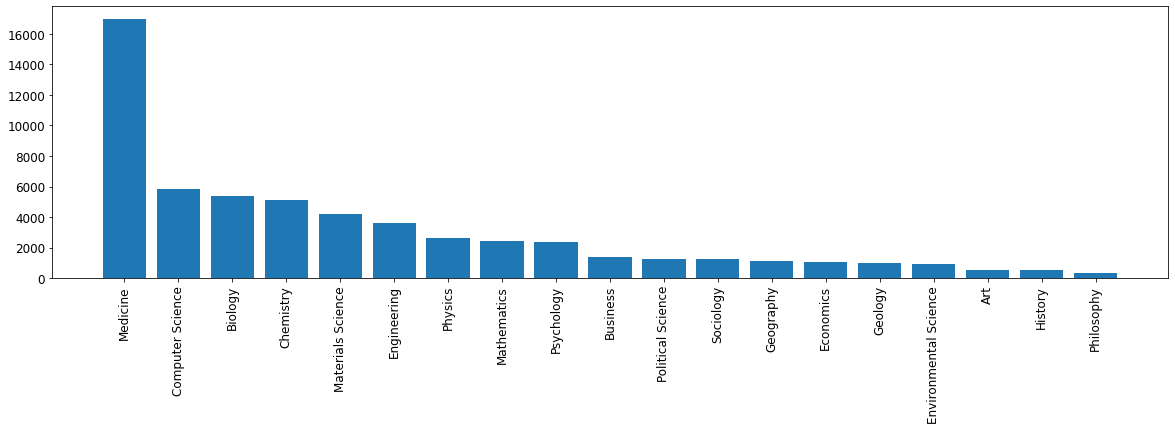

In [2]:
from collections import Counter
import matplotlib.pyplot as plt

domains, counts = zip(*Counter(y).most_common())

# Configure matplotlib to have nice, high-resolution charts
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 12

plt.xticks(rotation=90)
plt.bar(domains, counts)
None

## Optimise and train Multinomial Naive Bayes classifier

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


def create_pipeline() -> Pipeline:
    return Pipeline(
        steps=[
            ("vectorizer", TfidfVectorizer(sublinear_tf=True)),
            ("classifier", MultinomialNB()),
        ]
    )

In [4]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

optimisation_pipeline = GridSearchCV(
    create_pipeline(),
    {
        "vectorizer__min_df": [5, 20, 100],
        "vectorizer__max_df": [0.05, 0.1],
        "classifier__alpha": [0.5, 1],
        "classifier__fit_prior": [True, False],
    },
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1,
)
optimisation_pipeline.fit(X, y)

results = pd.DataFrame(optimisation_pipeline.cv_results_)
results.sort_values("rank_test_score")

Fitting 3 folds for each of 24 candidates, totalling 72 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__fit_prior,param_vectorizer__max_df,param_vectorizer__min_df,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,14.549476,0.361685,8.476837,0.222398,0.5,False,0.05,20,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.518061,0.514842,0.511599,0.514834,0.002638,1
10,11.235289,0.130426,4.092868,0.082518,0.5,False,0.1,20,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.513897,0.515661,0.507867,0.512475,0.003337,2
19,7.383645,0.138110,4.130709,0.250048,1,False,0.05,20,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.496825,0.501045,0.496854,0.498241,0.001983,3
11,10.435154,0.305144,3.882101,0.128886,0.5,False,0.1,100,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.493247,0.497814,0.502245,0.497769,0.003674,4
8,13.643193,0.310696,4.173707,0.142980,0.5,False,0.05,100,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.489609,0.495207,0.498154,0.494323,0.003544,5
22,7.048340,0.050070,3.172948,0.152418,1,False,0.1,20,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.487456,0.493865,0.491157,0.490826,0.002627,6
23,7.564685,0.146092,2.374111,0.285026,1,False,0.1,100,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.485160,0.494039,0.490127,0.489776,0.003633,7
20,7.172353,0.212599,3.747219,0.130217,1,False,0.05,100,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.481303,0.490002,0.488269,0.486524,0.003759,8
6,14.276345,0.456576,8.318859,0.268701,0.5,False,0.05,5,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.482429,0.487735,0.484888,0.485017,0.002168,9
2,14.902358,0.737693,5.975091,0.171150,0.5,True,0.05,100,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.469598,0.474490,0.473637,0.472575,0.002134,10


In [5]:
from sklearn import set_config

set_config(display="diagram")

classifier = create_pipeline()
classifier.set_params(**optimisation_pipeline.best_params_)
classifier.fit(X, y)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.05, min_df=20, sublinear_tf=True)),
                ('classifier', MultinomialNB(alpha=0.5, fit_prior=False))])

## Export the model using GreatAI

In [6]:
from great_ai import save_model


save_model(classifier, key="small-domain-prediction", keep_last_n=5)

Fetching cached versions of small-domain-prediction
Copying file for small-domain-prediction-2
Compressing small-domain-prediction-2
Model small-domain-prediction uploaded with version 2


'small-domain-prediction:2'

## Next: [Part 3](/examples/simple/deploy)